In [14]:
import matplotlib.pyplot as plt
import numpy as np
import meshplot as mp
import gudhi                 as gd
from sklearn.cluster import KMeans, AgglomerativeClustering
from mapper import MapperComplex
import itertools
from pyvis.network import Network
from scipy.spatial.distance import  directed_hausdorff
from joblib import Parallel, delayed

from numpy.random import normal, uniform
from ot import gromov_wasserstein
from tqdm import tqdm

In [2]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

In [3]:
vertices, faces = off2numpy(r'Datasets/human.off')
mp.plot(vertices,faces);

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.035629…

In [4]:
n_clusters=3
resolutions=np.array([25])
gain=np.array([0.3])

sigma=0.01

kmeans=KMeans(n_clusters=n_clusters,init='random',n_init=100)



In [5]:
f=vertices @ np.array([[0],[1],[0]])

mapper=MapperComplex(colors=f,filters=f,resolutions=resolutions, gains=gain, clustering=kmeans)
mapper.fit(vertices)


MapperComplex(clustering=KMeans(init='random', n_clusters=3, n_init=100),
              colors=array([[-0.012561],
       [ 0.140958],
       [-0.048601],
       ...,
       [-0.958623],
       [ 0.081926],
       [-0.039107]]),
              filter_bnds=array([[-0.964406,  0.930527]]),
              filters=array([[-0.012561],
       [ 0.140958],
       [-0.048601],
       ...,
       [-0.958623],
       [ 0.081926],
       [-0.039107]]),
              gains=array([0.3]), resolutions=array([25]))

In [6]:
for k in mapper.node_info.keys():
    mapper.node_info[k]['colors']=mapper.node_info[k]['size']

In [7]:
nt=mapper.get_pyvis()
nt.show('human_initial.html')

human_initial.html


In [8]:
def max_dis(i,j,points,dd,D):
    I=list(dd.keys())[i]
    J=list(dd.keys())[j]
    if dd[I].size==0 or dd[J].size==0:
        return D
    return np.max((directed_hausdorff(points[dd[I],:],points[dd[J],:])[0],directed_hausdorff(points[dd[J],:],points[dd[I],:])[0]))

In [9]:
def get_ot_params(mapper,mes,points,D):

    dd={}
    st=mapper.simplex_tree
    for k in mapper.node_info.keys():
        dd[k]=mapper.node_info[k]['indices']

    for (splx,_) in st.get_skeleton(1):
        if len(splx) == 2:
            dd[str(splx)]=np.intersect1d(dd[splx[0]], dd[splx[1]],assume_unique=True)
            dd[splx[0]]=np.setdiff1d(dd[splx[0]], dd[str(splx)], assume_unique=True)
            dd[splx[1]]=np.setdiff1d(dd[splx[1]], dd[str(splx)], assume_unique=True)

    p=np.array([mes[dd[k]].sum() for k in dd.keys()])
    inds=np.triu_indices(len(dd.keys()))

    #dm=distance_matrix(vertices, vertices)

    out=Parallel(n_jobs=-1)(delayed(max_dis)(i, j,points,dd,D) for (i,j) in zip(*inds))

    C=np.zeros((len(dd.keys()),len(dd.keys())))

    l=list(zip(*inds))
    for k in range(len(l)):
        v=out[k]
        (i,j)=l[k]
        C[i,j]=v
        C[j,i]=v

    return(p,C)

# Change measure

In [15]:
mes=np.repeat(1,vertices.shape[0])/vertices.shape[0]

In [16]:
(p1,C)=get_ot_params(mapper,mes,vertices)

In [17]:
C

array([[0.        , 0.40383644, 0.40764345, ..., 1.81363108, 1.82677115,
        1.80651788],
       [0.40383644, 0.        , 0.16040566, ..., 1.81573306, 1.84570794,
        1.83936017],
       [0.40764345, 0.16040566, 0.        , ..., 1.8218076 , 1.83212288,
        1.8301084 ],
       ...,
       [1.81363108, 1.81573306, 1.8218076 , ..., 0.        , 0.20636903,
        0.16401842],
       [1.82677115, 1.84570794, 1.83212288, ..., 0.20636903, 0.        ,
        0.13745722],
       [1.80651788, 1.83936017, 1.8301084 , ..., 0.16401842, 0.13745722,
        0.        ]])

In [18]:
from sklearn.neighbors import KernelDensity

kd=KernelDensity()

kd.fit(vertices)

KernelDensity()

In [19]:
mes_kd=np.exp(kd.score_samples(vertices))

In [20]:
mes_kd=mes_kd/mes_kd.sum()

In [21]:
p2=np.array([mes_kd[dd[k]].sum() for k in dd.keys()])

In [22]:
from ot import gromov_wasserstein

In [23]:
T,l=gromov_wasserstein(C, C, p=p1, q=p2,symmetric=True,log=True)

In [24]:
l['gw_dist']

0.004261790457918489

# Change function

In [11]:
vertices

array([[ 0.069992, -0.012561,  0.002292],
       [-0.011686,  0.140958, -0.169579],
       [ 0.06238 , -0.048601,  0.138192],
       ...,
       [-0.041064, -0.958623,  0.173813],
       [-0.028685,  0.081926, -0.421906],
       [ 0.089337, -0.039107, -0.051937]])

In [15]:
def f(t):
    return vertices @ (t*np.array([[0],[1],[0]])+(1-t)*np.array([[1],[0],[0]]))

In [17]:
mes=np.repeat(1,vertices.shape[0])/vertices.shape[0]
(p1,C1)=get_ot_params(mapper,mes,vertices,2)

l=[]
for t in tqdm(np.linspace(0,1,20)):
    mapper1=MapperComplex(colors=f(t),filters=f(t),resolutions=resolutions, gains=gain, clustering=kmeans)
    mapper1.fit(vertices)
    (p2,C2)=get_ot_params(mapper1,mes,vertices,2)
    T1,l1=gromov_wasserstein(C1, C2, p=p1, q=p2,symmetric=True,log=True)
    l.append(l1['gw_dist'])

100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


In [18]:
x=[np.max(f(t)-f(1)) for t in np.linspace(0,1,20)]

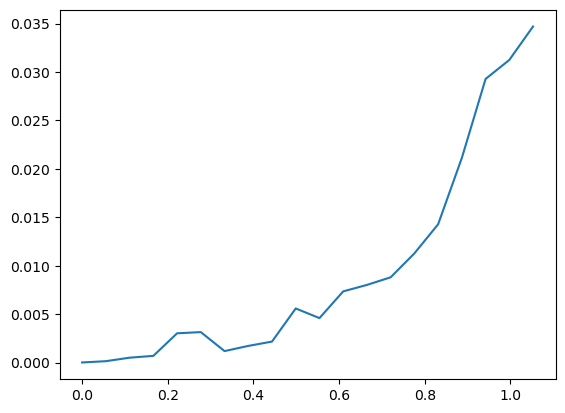

In [19]:
plt.plot(x,l)
plt.savefig('ot_filter.png')

# Noise

In [27]:
noise=uniform(low=1/2,size=300).reshape((-1,3))

In [28]:
noisy_data=np.concatenate((noise,vertices))

In [62]:
f=noisy_data @ np.array([[0],[1],[0]])

ag=AgglomerativeClustering(n_clusters=5)

mapper=MapperComplex(colors=f,filters=f,resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(noisy_data)

MapperComplex(clustering=AgglomerativeClustering(n_clusters=5),
              colors=array([[ 0.59593913],
       [ 0.7703868 ],
       [ 0.86204279],
       ...,
       [-0.958623  ],
       [ 0.081926  ],
       [-0.039107  ]]),
              filter_bnds=array([[-0.964406  ,  0.99759129]]),
              filters=array([[ 0.59593913],
       [ 0.7703868 ],
       [ 0.86204279],
       ...,
       [-0.958623  ],
       [ 0.081926  ],
       [-0.039107  ]]),
              gains=array([0.3]), resolutions=array([25]))

In [63]:
from sklearn.neighbors import KernelDensity

kd=KernelDensity()

kd.fit(noisy_data)

mesn=np.exp(kd.score_samples(noisy_data))

In [64]:
mesn=mesn/mesn.sum()

In [65]:
mesn

array([6.90827205e-05, 4.52029706e-05, 5.32432334e-05, ...,
       8.17299614e-05, 1.08784961e-04, 1.17988000e-04])

In [66]:
(pn,Cn)=get_ot_params(mapper,mesn,noisy_data)

In [67]:
pn.shape

(311,)

In [68]:
for k in mapper.node_info.keys():
    mapper.node_info[k]['colors']=pn[k]

In [69]:
nt=mapper.get_pyvis()
nt.show('noise.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
